# Dataset analysis

In [140]:
import os
import sqlite3

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # type: ignore

from config import DB_PATH

In [38]:
connection = sqlite3.connect(DB_PATH)

### SMC claim dataset:

In [78]:
# Number Sentences
pd.read_sql_query("""
SELECT sentence_ID
FROM Sentence 
""", connection).count()

sentence_ID    25040
dtype: int64

In [79]:
# Number press briefing
pd.read_sql_query("""
SELECT pb_ID
FROM Press_Briefing 
""", connection).count()

pb_ID    53
dtype: int64

In [81]:
# Number passages
pd.read_sql_query("""
SELECT segment_ID
FROM Segment 
""", connection).count()

segment_ID    3066
dtype: int64

In [18]:
# Number sentences per speaker and resort
pd.read_sql_query("""
SELECT Press_Briefing.resort, count(DISTINCT Sentence.segment_ID) as num_segment, afiliation
FROM Sentence
JOIN Segment
ON Segment.segment_ID = Sentence.segment_ID
JOIN Person
ON Person.person_ID = Segment.speaker
JOIN Press_Briefing
ON Press_Briefing.pb_ID = Sentence.pb_ID
GROUP BY Press_Briefing.resort, afiliation
""", connection)

,resort,num_passages,afiliation
0,Klima,139,None
1,Klima,96,SMC
2,Medizin,1300,None
3,Medizin,1023,SMC
4,Technik,258,None
5,Technik,159,SMC
6,Wissenschaft,22,None
7,Wissenschaft,16,SMC


In [12]:
# Number guest passages
aff = pd.read_sql_query("""
SELECT *
FROM Segment
JOIN Person
ON Person.person_ID = Segment.speaker
""", connection)

aff[aff["afiliation"]!="SMC"]["segment_ID"].count()

1719

In [13]:
# Number moderator passages
aff[aff["afiliation"]=="SMC"]["segment_ID"].count()

1294

In [10]:
# Number guests
pd.read_sql_query("""
SELECT afiliation, COUNT(DISTINCT is_guest.person_ID) as num_guests
FROM is_guest
JOIN Person
ON Person.person_ID = is_guest.person_ID
GROUP BY afiliation
""", connection)

,afiliation,num_guests
0,None,177
1,SMC,9


In [78]:
# Avg Number guests
num_person = pd.read_sql_query("""
SELECT pb_ID , COUNT( DISTINCT person_ID) as num_guests
FROM is_guest
GROUP BY pb_ID
""", connection)

<AxesSubplot:>

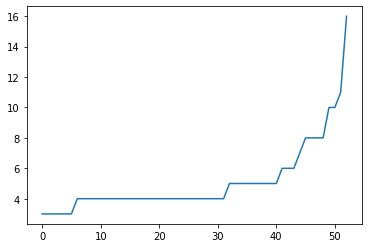

In [92]:
plt.figure(facecolor="white")
num_person["num_guests"].sort_values().reset_index(drop=True).plot.line()

In [96]:
q_hi  = num_person["num_guests"].quantile(0.9)  # exclude top .1 percetiles as outliers

num_person[num_person["num_guests"] < q_hi]["num_guests"].mean()

4.266666666666667

In [32]:
# Number sentences per speaker and resort
pd.read_sql_query("""
SELECT Press_Briefing.resort, count(sentence_ID) as num_sentences, afiliation
FROM Sentence
JOIN Segment
ON Segment.segment_ID = Sentence.segment_ID
JOIN Person
ON Person.person_ID = Segment.speaker
JOIN Press_Briefing
ON Press_Briefing.pb_ID = Sentence.pb_ID
GROUP BY Press_Briefing.resort, afiliation
""", connection)

,resort,num_sentences,afiliation
0,Klima,1409,None
1,Klima,389,SMC
2,Medizin,13973,None
3,Medizin,4696,SMC
4,Technik,3292,None
5,Technik,777,SMC
6,Wissenschaft,268,None
7,Wissenschaft,93,SMC


In [29]:
# Number PB per resort
pb_resort = pd.read_sql_query("""
SELECT resort, count(pb_ID) as num_resort
FROM Press_Briefing
GROUP BY resort
""", connection)
pb_resort

,resort,num_resort
0,Klima,4
1,Medizin,39
2,Technik,9
3,Wissenschaft,1


In [275]:
# Number PB per resort
pb_resort = pd.read_sql_query("""
SELECT *
FROM Press_Briefing
WHERE resort = "Wissenschaft"
""", connection)
pb_resort["pdf_url"].iloc[0]

'https://www.sciencemediacenter.de/fileadmin/user_upload/Press_Briefing_Zubehoer/Transkript_Preprints_Unsicherheit_SMC_Press-Briefing_20052020.pdf'

<AxesSubplot:xlabel='resort'>

<Figure size 432x288 with 0 Axes>

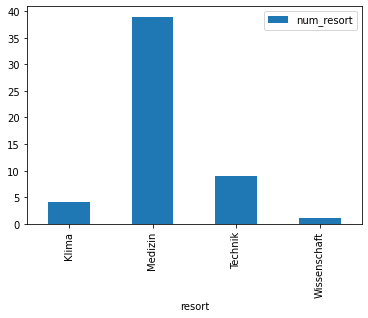

In [36]:
pb_resort.set_index("resort").plot.bar()

In [39]:
# Mean sentence length
sentences = pd.read_sql_query("""
SELECT Press_Briefing.resort, afiliation, Sentence_ID, Press_Briefing.pb_ID, Sentence
FROM Sentence
JOIN Segment
ON Segment.segment_ID = Sentence.segment_ID
JOIN Person
ON Person.person_ID = Segment.speaker
JOIN Press_Briefing
ON Press_Briefing.pb_ID = Sentence.pb_ID
""", connection)
sentences.head()

,resort,afiliation,sentence_ID,pb_ID,sentence
0,Medizin,SMC,2,1,Herzlich willkommen zum heutigen Press Briefin...
1,Medizin,SMC,3,1,"Mein Name ist Moderatorin, ich bin Redakteurin..."
2,Medizin,SMC,4,1,Ich begrüße die teilnehmenden Journalisten und...
3,Medizin,SMC,5,1,"Der Herbst ist da, die Infektionszahlen steige..."
4,Medizin,SMC,6,1,Und ein langsamer Anstieg der Neuaufnahmen von...


In [40]:
sentences["sentence_len"] = sentences["sentence"].apply(lambda x: len(x.split(" ")))  # split sentences at whitespace and count

<AxesSubplot:>

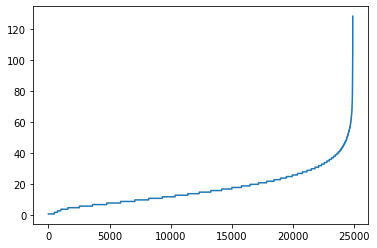

In [41]:
plt.figure(facecolor="white")
sentences["sentence_len"].sort_values().reset_index(drop=True).plot.line()

In [42]:
sentences["sentence_len"].mean()

17.307065108245972

In [43]:
# mean sentence length speaker and guest
sentences.afiliation.fillna("No", inplace=True)  # create countable non value

In [44]:
sentences.groupby("afiliation").mean()["sentence_len"]

afiliation
No     18.043976
SMC    14.963056
Name: sentence_len, dtype: float64

<AxesSubplot:title={'center':'sentence_len'}, xlabel='resort'>

<Figure size 432x288 with 0 Axes>

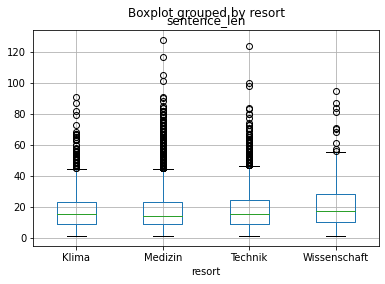

In [45]:
plt.figure(facecolor="white")
sentences.boxplot(column=['sentence_len'], by="resort")

In [28]:
sentences.groupby(by="resort").mean()["sentence_len"]

resort
Klima           17.575083
Medizin         17.099523
Technik         17.855247
Wissenschaft    20.526316
Name: sentence_len, dtype: float64

In [186]:
# Zeit
pbs = pd.read_sql_query("""
SELECT date, resort
FROM Press_Briefing 
""", connection)
pbs.head()

,date,resort
0,09.10.2020,Medizin
1,15.09.2017,Medizin
2,12.04.2019,Technik
3,08.06.2021,Klima
4,09.04.2020,Medizin


In [187]:
pbs.date = pd.to_datetime(pbs['date'], format='%d.%m.%Y')

In [188]:
print(pbs.date.min().date())

2017-03-21


In [189]:
print(pbs.date.max().date())

2021-08-04


<AxesSubplot:xlabel='date'>

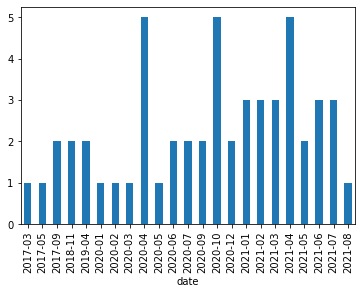

In [190]:
# pro jahr
plt.figure(facecolor="white")
pbs.groupby(pbs.date.dt.to_period("m")).agg('count')["resort"].plot.bar()

<AxesSubplot:xlabel='date'>

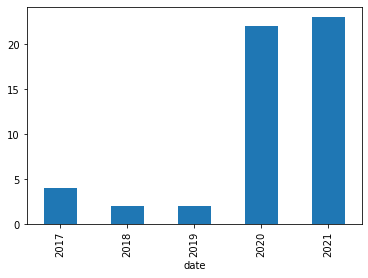

In [198]:
# 2021 nur halb
plt.figure(facecolor="white")
pbs.groupby(pbs.date.dt.to_period("y")).agg('count')["resort"].plot.bar(stacked=True)

<AxesSubplot:xlabel='date'>

<Figure size 432x288 with 0 Axes>

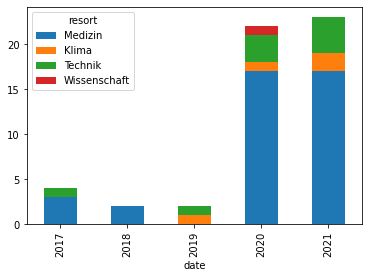

In [270]:
# 2021 nur halb
df = pbs.groupby([pbs.date.dt.to_period("y"), "resort"]).count().rename(columns={'date':'count'}).reset_index()
plotdata = pd.pivot_table(df, values='count', index='date', columns='resort')
plotdata = plotdata[["Medizin", "Klima", "Technik", "Wissenschaft"]]
plt.figure(facecolor="white")
plotdata.plot(kind="bar", stacked=True)

In [271]:
plotdata.fillna(0, inplace=True)

Text(0, 0.5, 'Percentage Pies Consumed (%)')

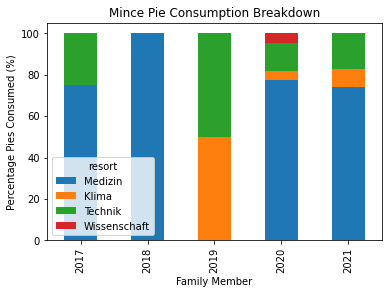

In [272]:
stacked_data = plotdata.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True)
plt.title("Mince Pie Consumption Breakdown")
plt.xlabel("Family Member")
plt.ylabel("Percentage Pies Consumed (%)")

In [192]:
pbs.count()/abs((pbs.date.min() - pbs.date.max())/np.timedelta64(1, 'M'))

date      1.010115
resort    1.010115
dtype: float64

In [284]:
(1719/ 3066)

0.5606653620352251

In [286]:
(1294/3066) 

0.42204827136333983

In [289]:
5955 / (5955 + 18942)1:

0.23918544402940115

In [290]:
18942 / (5955 + 18942)

0.7608145559705989

### Main Concept

In [ ]:
# Sentence with max confidence main concept
pd.read_sql_query("""
SELECT Sentence.sentence_ID, sentence, term, wiki_num, max(confidence)
FROM Sentence 
JOIN Sentence_Wikification 
ON Sentence.sentence_ID = Sentence_Wikification.sentence_ID
GROUP BY Sentence_Wikification.sentence_ID
HAVING max(confidence) > 0.5""", connection)  # + topic , resort

In [ ]:
# find PB by term from title
pd.read_sql_query("""
SELECT *
FROM Press_Briefing
WHERE title LIKE '%quanten%'""", connection).head()

In [ ]:
# Qanten PB with main concept
pd.read_sql_query("""
SELECT *
FROM Sentence 
JOIN Sentence_Wikification 
ON Sentence.sentence_ID = Sentence_Wikification.sentence_ID
WHERE pb_ID = 10
""", connection).head()

### 

### Pre labeled data translate train

In [12]:
data = pd.read_csv(os.path.join("data", "SMC_dataset", "pre_labeled", "SMC_claim_setences_pre.csv"), names=["sentence_ID", "title", "sentence", "prob"])
data.head()

<AxesSubplot:title={'center':'Predicted claim probability'}, xlabel='Sentences', ylabel='Predicted claim probability'>

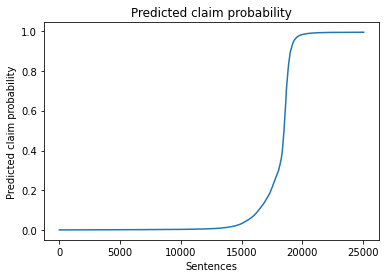

In [47]:
plt.figure(facecolor="white")
data.prob.sort_values().reset_index(drop=True).plot.line(xlabel="Sentences", ylabel="Predicted claim probability", title="Predicted claim probability")

In [53]:
data.prob.quantile([.1, .2, .3, .4,.5,.6,.7,.8,.9])

0.1    0.002265
0.2    0.002811
0.3    0.003383
0.4    0.004409
0.5    0.007969
0.6    0.034142
0.7    0.218444
0.8    0.982467
0.9    0.992475
Name: prob, dtype: float64